# Problem Statement:
    
A study on unsupervised learning techniques, market basket analysis and recommendation systems on 'Anime Database'

## Feature Description

**Anime.csv** <br>

* anime_id - unique id identifying an anime.<br>
* name - full name of anime.<br>
* genre - comma separated list of genres for this anime.<br>
* type - movie, TV, OVA, etc.<br>
* episodes - how many episodes in this show. (1 if movie).<br>
* rating - average rating out of 10 for this anime.<br>
* members - number of community members that are in this anime's
"group".<br>

**Rating.csv**<br>

* user_id - non identifiable randomly generated user id.<br>
* anime_id - the anime that this user has rated.<br>
* rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).<br>

## Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
import plotly
from mlxtend.frequent_patterns import apriori, association_rules
plotly.offline.init_notebook_mode(connected=True)
from mlxtend.preprocessing import TransactionEncoder
pd.options.display.float_format = '{:.6f}'.format
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error

from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import SVDpp
from wordcloud import WordCloud
from sklearn.decomposition import PCA
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [10,8]
plt.style.use('ggplot')

## Loading of anime and rating data

In [2]:
anime=pd.read_csv("anime.csv")
rating=pd.read_csv("rating.csv")
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama,Romance,School,Supernatural",Movie,1,9.370000,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action,Adventure,Drama,Fantasy,Magic,Military,...",TV,64,9.260000,793665
2,28977,Gintama°,"Action,Comedy,Historical,Parody,Samurai,Sci-Fi...",TV,51,9.250000,114262
3,9253,Steins;Gate,"Sci-Fi,Thriller",TV,24,9.170000,673572
4,9969,Gintama&#039;,"Action,Comedy,Historical,Parody,Samurai,Sci-Fi...",TV,51,9.160000,151266


In [3]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [4]:
anime=anime[anime['episodes']!='Unknown']
anime['episodes']=anime['episodes'].astype('int')
anime['episodes'].dtype

dtype('int32')

In [5]:
anime_fulldata=pd.merge(anime,rating,on='anime_id',suffixes= ['', '_user'])
anime_fulldata = anime_fulldata.rename(columns={'name': 'anime_title', 'rating_user': 'user_rating'})
anime_fulldata.head()

,anime_id,anime_title,genre,type,episodes,rating,members,user_id,user_rating
0,32281,Kimi no Na wa.,"Drama,Romance,School,Supernatural",Movie,1,9.370000,200630,99,5
1,32281,Kimi no Na wa.,"Drama,Romance,School,Supernatural",Movie,1,9.370000,200630,152,10
2,32281,Kimi no Na wa.,"Drama,Romance,School,Supernatural",Movie,1,9.370000,200630,244,10
3,32281,Kimi no Na wa.,"Drama,Romance,School,Supernatural",Movie,1,9.370000,200630,271,10
4,32281,Kimi no Na wa.,"Drama,Romance,School,Supernatural",Movie,1,9.370000,200630,278,-1


# Explanatory Data Analysis(EDA)

## Check for missing values

In [6]:
anime_fulldata.isna().sum()

anime_id         0
anime_title      0
genre          110
type             0
episodes         0
rating           2
members          0
user_id          0
user_rating      0
dtype: int64

## Dropping of missing values

In [7]:
anime_fulldata.dropna(inplace=True)

In [8]:
anime_fulldata['genre'] = anime_fulldata['genre'].apply(lambda x:x.split(',')[0])

In [9]:
anime_fulldata.head()

,anime_id,anime_title,genre,type,episodes,rating,members,user_id,user_rating
0,32281,Kimi no Na wa.,Drama,Movie,1,9.370000,200630,99,5
1,32281,Kimi no Na wa.,Drama,Movie,1,9.370000,200630,152,10
2,32281,Kimi no Na wa.,Drama,Movie,1,9.370000,200630,244,10
3,32281,Kimi no Na wa.,Drama,Movie,1,9.370000,200630,271,10
4,32281,Kimi no Na wa.,Drama,Movie,1,9.370000,200630,278,-1


# Descriptive analysis

In [11]:
anime.describe()

,anime_id,episodes,rating,members
count,11954.000000,11954.000000,11876.000000,11954.000000
mean,13589.705120,12.382550,6.480333,18368.561402
std,11209.052798,46.865352,1.021995,55110.775838
min,1.000000,1.000000,1.670000,5.000000
25%,3380.250000,1.000000,5.890000,229.000000
50%,9934.500000,2.000000,6.570000,1579.500000
75%,23644.500000,12.000000,7.182500,9755.500000
max,34527.000000,1818.000000,10.000000,1013917.000000


### Distribution of people's rating w.r.t std and mean

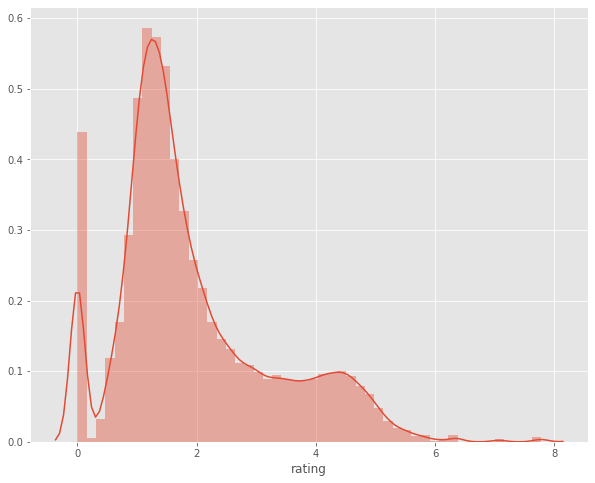

In [12]:
# group by user_id and checking for std

st=rating.groupby('user_id')['rating'].std()
sns.distplot(st)
plt.show()

**Inference:**

* Some people have only a single rating (likely the spike at 0)
* A lot of people shuffle their ratings 1-2 points.
* Some people have huge variance.

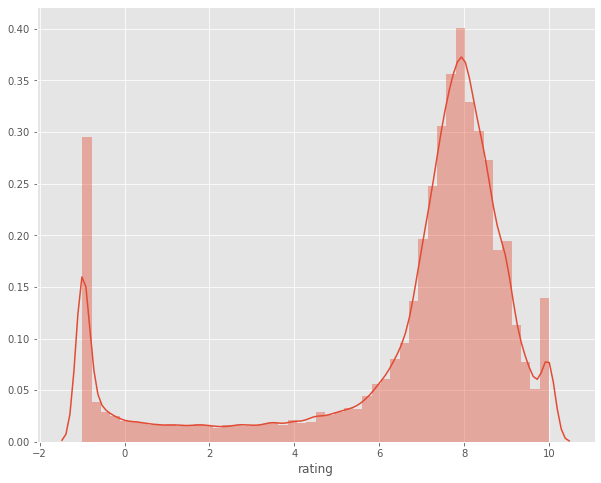

In [13]:
# group by user_id and checking for mean

st=rating.groupby('user_id')['rating'].mean()
sns.distplot(st)
plt.show()

**Inference:**

* In general, most people rate the shows they like.
* Some people only ratings things 10/10.
* Most people rating things, on average, around an 8.0/10

### Ratings vs number of episodes

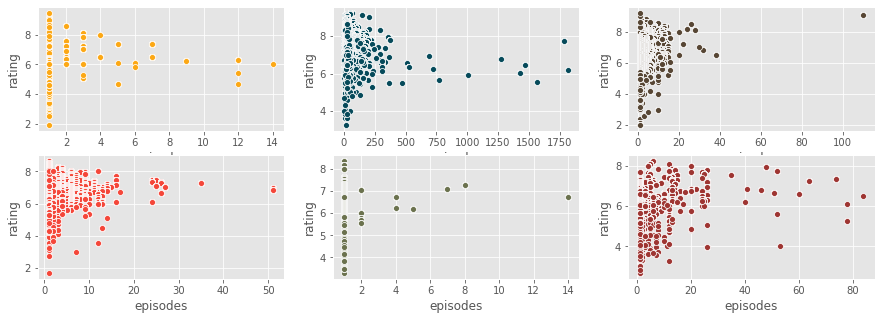

In [14]:
plt.figure(figsize=(15,5))
types=anime['type'].unique()
color=['#fca815', '#064a5a', '#574634', '#f4473a','#6b724e', '#9e3532']
for i,j in enumerate(types):
    plt.subplot(2,3,i+1)
    group= anime_fulldata[anime_fulldata['type']==j]
    sns.scatterplot(group['episodes'],group['rating'],color=color[i])

### Distribution of Ratings

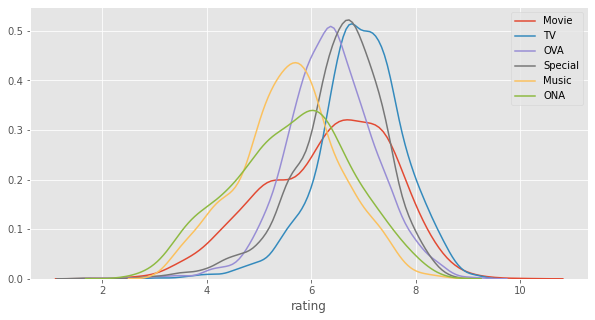

In [15]:
plt.figure(figsize=(10,5))
types=anime['type'].unique()
for i in types:
    sns.distplot(anime[anime['type']== i]['rating'],hist=False,label=i)
plt.show()

### Average rating by type

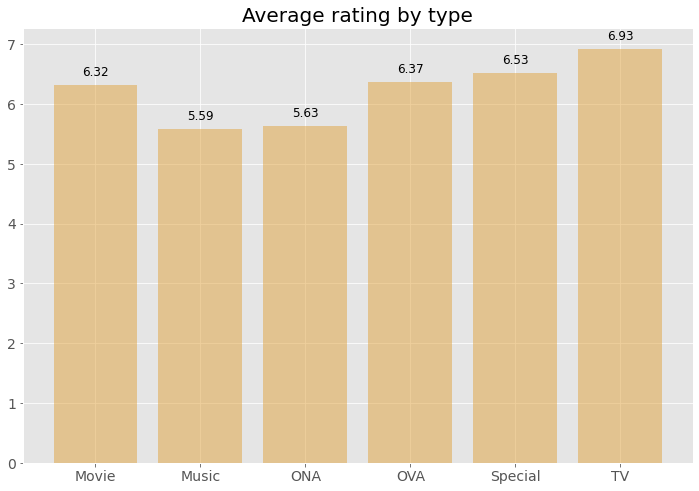

In [17]:
data=anime['rating'].groupby(anime.type).mean()
x=data.index
y=data.values

plt.figure(figsize=(12,8))
plt.title('Average rating by type',fontsize=20)
plt.bar(x,y,color='#e0a23d',alpha=0.5)
for i,j in zip(x,y):
    plt.text(i,j+0.1,'%.2f'%j,ha='center',va='bottom',fontsize=12)
plt.tick_params(labelsize=14)
plt.show()

TV has the highest score, with an average score close to 7.

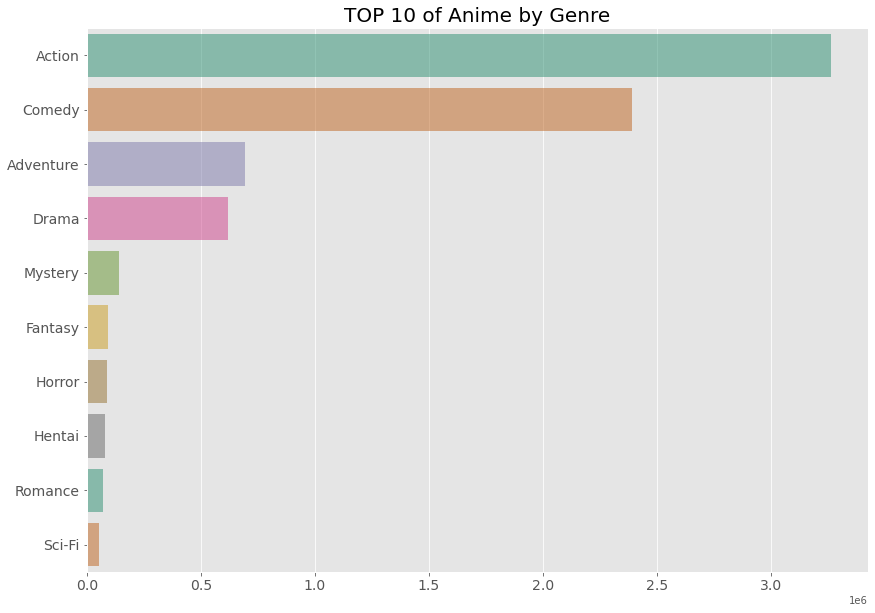

In [18]:
x=anime_fulldata.genre.value_counts()[:10].index
y=anime_fulldata.genre.value_counts()[:10].values

plt.figure(figsize=(14,10))
sns.barplot(y, x, color='g', alpha=0.5, palette='Dark2')
plt.title('TOP 10 of Anime by Genre', fontsize=20)
plt.tick_params(labelsize=14)

**Major anime are Action, Comedy, Adventure and Drama**

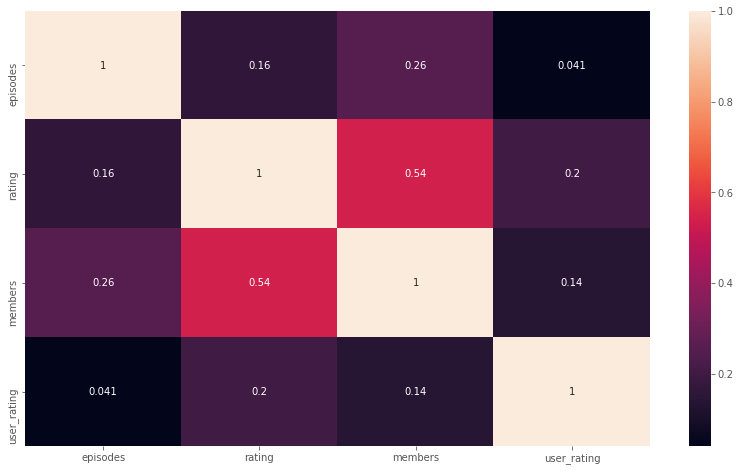

In [19]:
plt.figure(figsize=(14,8))
anime_fulldata_copy = anime_fulldata.copy()
anime_fulldata_copy['anime_id'] = anime_fulldata_copy['anime_id'].astype('O')
anime_fulldata_copy['user_id'] = anime_fulldata_copy['user_id'].astype('O')
sns.heatmap(anime_fulldata_copy.corr(), annot=True)
plt.show()

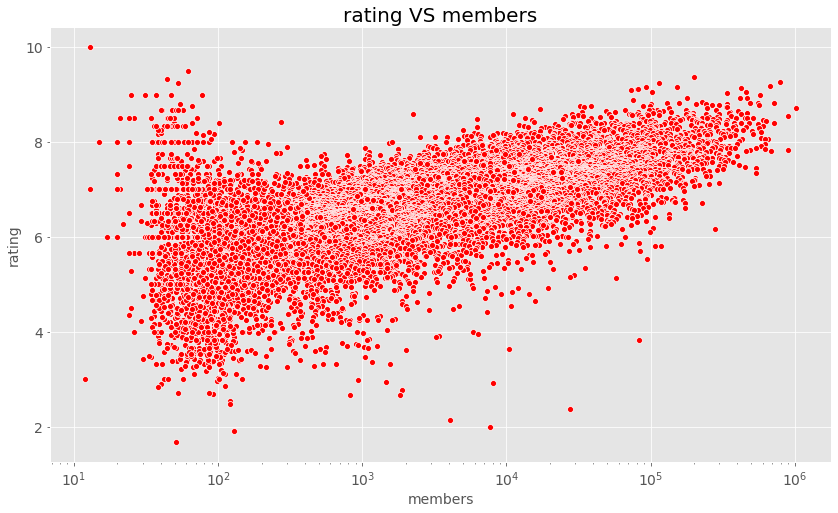

In [20]:
x=anime['members']
y=anime['rating']

plt.figure(figsize=(14,8))
sns.scatterplot(x,y,color='red')
ax=plt.gca()
ax.set_xscale('log')
plt.title('rating VS members',fontsize=20)
plt.tick_params(labelsize=14)
plt.xlabel('members',fontsize=14)
plt.ylabel('rating',fontsize=14)
plt.show()

As the number of people who like anime increases, the anime ratings increases.

# Clustering of Anime

In [21]:
anime_fulldata.head()

,anime_id,anime_title,genre,type,episodes,rating,members,user_id,user_rating
0,32281,Kimi no Na wa.,Drama,Movie,1,9.370000,200630,99,5
1,32281,Kimi no Na wa.,Drama,Movie,1,9.370000,200630,152,10
2,32281,Kimi no Na wa.,Drama,Movie,1,9.370000,200630,244,10
3,32281,Kimi no Na wa.,Drama,Movie,1,9.370000,200630,271,10
4,32281,Kimi no Na wa.,Drama,Movie,1,9.370000,200630,278,-1


In [22]:
anime_fulldata_new=anime_fulldata.copy()

In [23]:
anime_fulldata_new.head()

,anime_id,anime_title,genre,type,episodes,rating,members,user_id,user_rating
0,32281,Kimi no Na wa.,Drama,Movie,1,9.370000,200630,99,5
1,32281,Kimi no Na wa.,Drama,Movie,1,9.370000,200630,152,10
2,32281,Kimi no Na wa.,Drama,Movie,1,9.370000,200630,244,10
3,32281,Kimi no Na wa.,Drama,Movie,1,9.370000,200630,271,10
4,32281,Kimi no Na wa.,Drama,Movie,1,9.370000,200630,278,-1


# KMEANS Clustering

 Subsetting the data from these genres   **["Sci-Fi","Psychological","Game","Historical","Magic","Kids"]**  in order to preserve the pattern or similarities among the records

In [24]:
anime_fulldata_new=anime_fulldata_new[(anime_fulldata_new.genre=="Sci-Fi")|(anime_fulldata_new.genre=="Psychological")|(anime_fulldata_new.genre=="Game")|(anime_fulldata_new.genre=="Magic")|(anime_fulldata_new.genre=="Kids")|(anime_fulldata_new.genre=="Historical")]
anime_fulldata_new=anime_fulldata_new.drop_duplicates()
anime_fulldata_new.reset_index(inplace=True, drop=True)
anime_fulldata_new.shape

(121343, 9)

In [25]:
anime_fulldata_new.genre.value_counts()

Sci-Fi           53615
Psychological    17106
Game             16248
Magic            15611
Historical       13038
Kids              5725
Name: genre, dtype: int64

In [26]:
anime_fulldata_new["anime_id"]=anime_fulldata_new["anime_id"].astype("object")
anime_fulldata_new["user_id"]=anime_fulldata_new["user_id"].astype("object")
anime_fulldata_new["episodes"]=anime_fulldata_new["episodes"].astype("int")

In [27]:
anime_fulldata_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121343 entries, 0 to 121342
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   anime_id     121343 non-null  object 
 1   anime_title  121343 non-null  object 
 2   genre        121343 non-null  object 
 3   type         121343 non-null  object 
 4   episodes     121343 non-null  int32  
 5   rating       121343 non-null  float64
 6   members      121343 non-null  int64  
 7   user_id      121343 non-null  object 
 8   user_rating  121343 non-null  int64  
dtypes: float64(1), int32(1), int64(2), object(5)
memory usage: 7.9+ MB


#### Considering only the numerical columns for clustering

In [28]:
anime_data_clustering=anime_fulldata_new[["rating","members","user_rating","episodes"]]
anime_data_clustering.head()

,rating,members,user_rating,episodes
0,9.170000,673572,9,24
1,9.170000,673572,-1,24
2,9.170000,673572,7,24
3,9.170000,673572,10,24
4,9.170000,673572,-1,24


In [29]:
anime_other_data=anime_fulldata_new.drop(columns=["rating","members","user_rating","episodes"])
anime_other_data.head()

,anime_id,anime_title,genre,type,user_id
0,9253,Steins;Gate,Sci-Fi,TV,5
1,9253,Steins;Gate,Sci-Fi,TV,10
2,9253,Steins;Gate,Sci-Fi,TV,11
3,9253,Steins;Gate,Sci-Fi,TV,12
4,9253,Steins;Gate,Sci-Fi,TV,13


#### Feature Scaling

In [30]:
mm=MinMaxScaler()
a=mm.fit_transform(anime_data_clustering)
b=anime_data_clustering.columns
df_num_mm=pd.DataFrame(a,columns=b)
df_num_mm.head()

,rating,members,user_rating,episodes
0,1.000000,1.000000,0.909091,0.014706
1,1.000000,1.000000,0.000000,0.014706
2,1.000000,1.000000,0.727273,0.014706
3,1.000000,1.000000,1.000000,0.014706
4,1.000000,1.000000,0.000000,0.014706


#### Optimal 'k' value using Elbow plot based on inertia

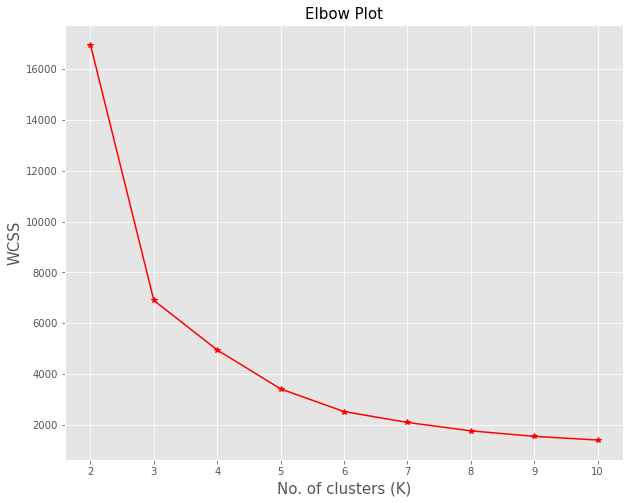

In [31]:
wcss  = []
for i in range(2,11):
    kmeans = KMeans(n_clusters = i, random_state = 10)
    kmeans.fit(df_num_mm)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(2,11), wcss,marker="*",color="red")

plt.title('Elbow Plot', fontsize = 15)
plt.xlabel('No. of clusters (K)', fontsize = 15)
plt.ylabel('WCSS', fontsize = 15)
plt.grid(True)
plt.show()

#### Optimal 'k' value using Silhouette Score 

In [32]:
n_clusters = range(2,11)
for K in n_clusters:
    cluster = KMeans (n_clusters= K, random_state= 10)
    predict = cluster.fit_predict(df_num_mm)
    score = silhouette_score(df_num_mm, predict, random_state= 10)
    print ("For {} clusters the silhouette score is {})".format(K, score))

For 2 clusters the silhouette score is 0.48791475690654357)
For 3 clusters the silhouette score is 0.6384432775764323)
For 4 clusters the silhouette score is 0.5105216832768239)
For 5 clusters the silhouette score is 0.5251199626494868)
For 6 clusters the silhouette score is 0.5074233226315293)
For 7 clusters the silhouette score is 0.5003137665226709)
For 8 clusters the silhouette score is 0.47043281079529137)
For 9 clusters the silhouette score is 0.4791380301194123)
For 10 clusters the silhouette score is 0.47397266180817366)


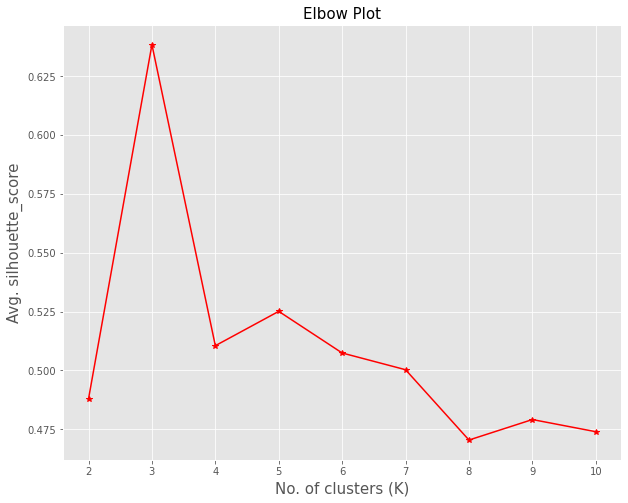

In [33]:
score  = []
for i in range(2,11):
    kmeans = KMeans(n_clusters = i, random_state = 10)
    kmeans.fit(df_num_mm)
    labels=kmeans.labels_
    ss=silhouette_score(df_num_mm,labels)
    score.append(ss)
plt.plot(range(2,11), score,marker="*",color="red")
plt.title('Elbow Plot', fontsize = 15)
plt.xlabel('No. of clusters (K)', fontsize = 15)
plt.ylabel('Avg. silhouette_score', fontsize = 15)
plt.grid(True)
plt.show()

### Fitting the scaled values for KMeans clustering with n_clusters = 3

In [87]:
cluster = KMeans (n_clusters= 3, random_state= 10)
predic = cluster.fit_predict(df_num_mm)
df_num_mm["cluster_label"]=predic

In [88]:
df_1=pd.concat([anime_data_clustering,anime_other_data,df_num_mm["cluster_label"]],axis=1)
df_1.head()

,rating,members,user_rating,episodes,anime_id,anime_title,genre,type,user_id,cluster_label
0,9.170000,673572,9,24,9253,Steins;Gate,Sci-Fi,TV,5,1
1,9.170000,673572,-1,24,9253,Steins;Gate,Sci-Fi,TV,10,2
2,9.170000,673572,7,24,9253,Steins;Gate,Sci-Fi,TV,11,1
3,9.170000,673572,10,24,9253,Steins;Gate,Sci-Fi,TV,12,1
4,9.170000,673572,-1,24,9253,Steins;Gate,Sci-Fi,TV,13,2


In [89]:
df_1.user_rating.value_counts()

 8     24112
 9     23546
 10    21884
-1     20309
 7     17302
 6      8054
 5      3648
 4      1412
 3       619
 2       268
 1       189
Name: user_rating, dtype: int64

#### Reinitializing user rating from zero instead of -1

In [90]:
df_1.user_rating=df_1.user_rating+1

In [91]:
df_1.user_rating.value_counts()

9     24112
10    23546
11    21884
0     20309
8     17302
7      8054
6      3648
5      1412
4       619
3       268
2       189
Name: user_rating, dtype: int64

### Profiling

#### Profiling of cluster labels with the considered numerical columns

In [92]:
df_1.groupby(["cluster_label"]).mean()

,rating,members,user_rating,episodes
cluster_label,,,,
0,7.957233,91039.627826,6.816777,10.480113
1,7.814755,270976.641661,8.602278,14.942778
2,8.199537,360261.920006,7.429611,17.476269


**Observations:**<br>
1. Cluster 2 has highest average rating, where as Cluster 0 and 1 have same average rating.
2. Cluster 2 has the highest members subscribed with the highest average episodes.

In [93]:
df_1[df_1['cluster_label']==0]['type'].value_counts()

TV         24156
Movie      15849
Special    10861
ONA         3706
OVA         2014
Music        159
Name: type, dtype: int64

In [94]:
df_1[df_1['cluster_label']==1]['type'].value_counts()

TV         29007
Movie       7856
OVA         4046
Special     3491
ONA         1209
Music        300
Name: type, dtype: int64

In [95]:
df_1[df_1['cluster_label']==2]['type'].value_counts()

TV       18515
Movie      174
Name: type, dtype: int64

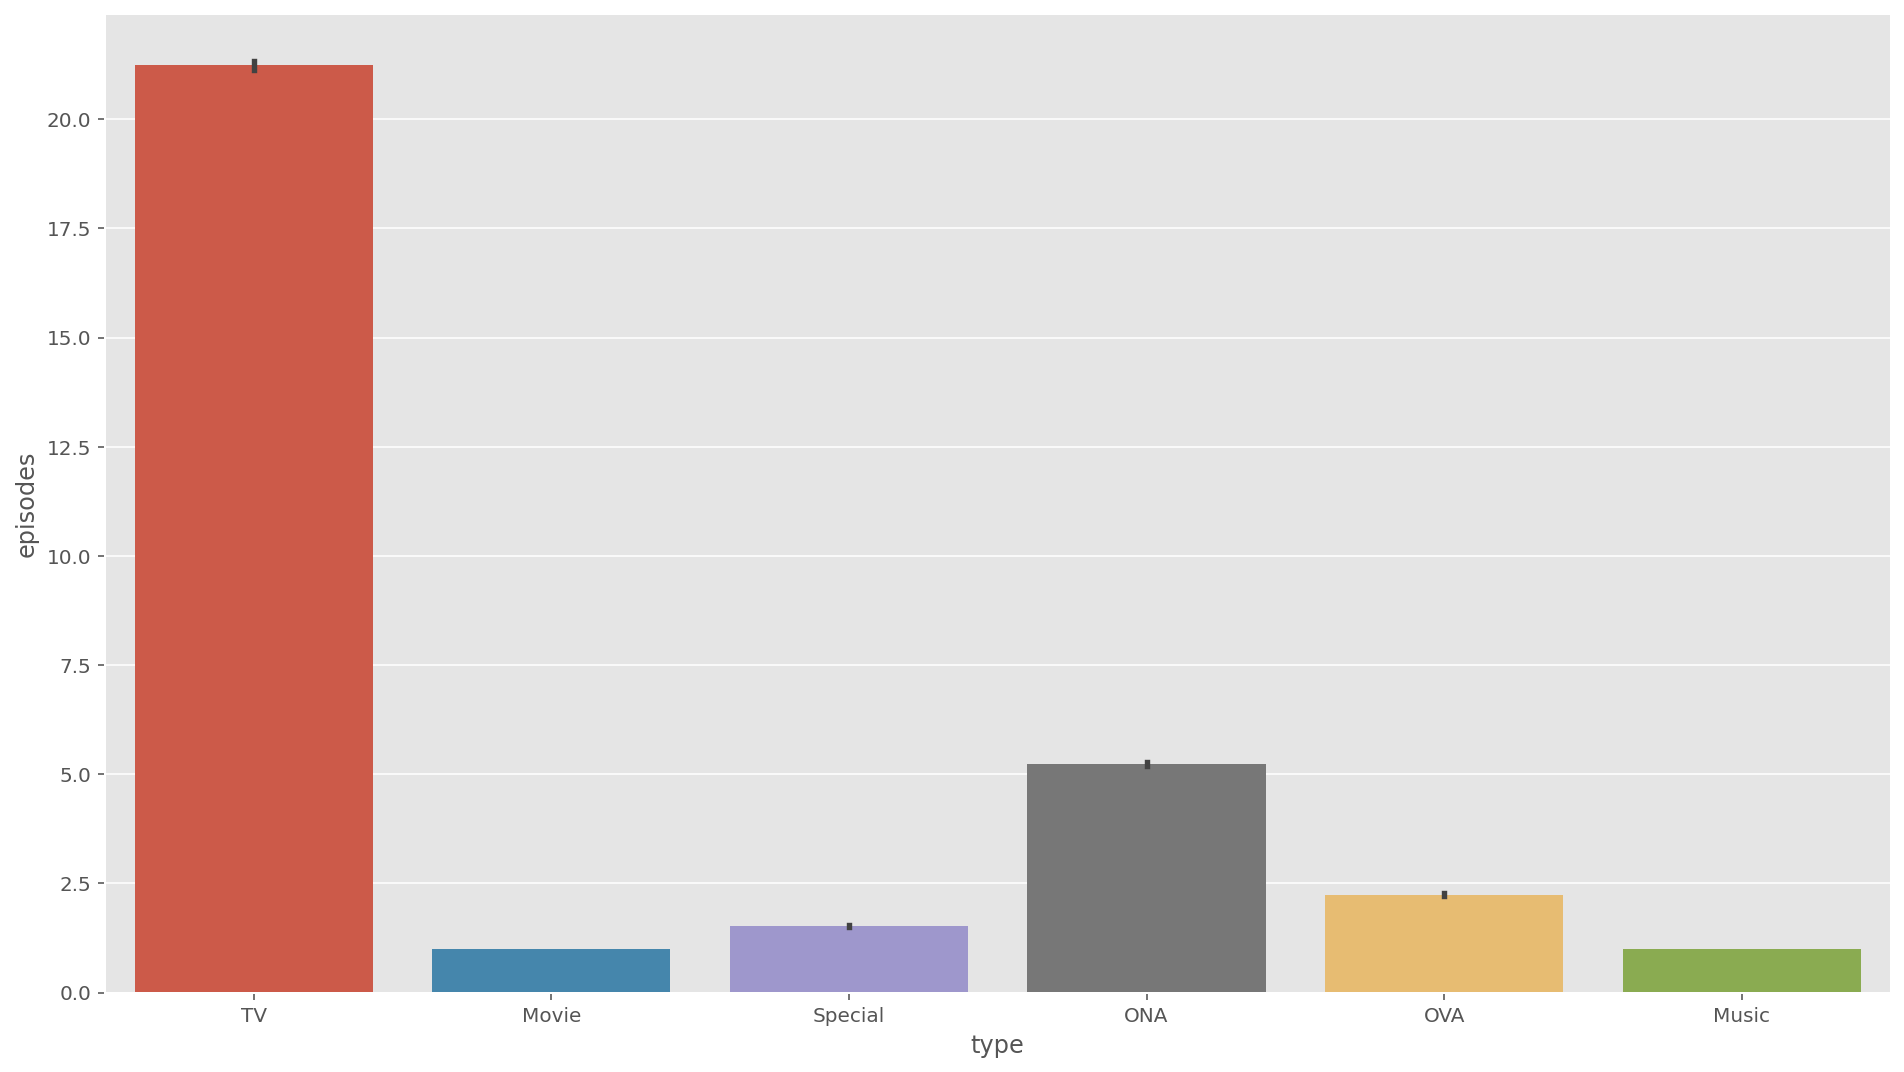

In [96]:
sns.barplot(x=df_1['type'], y=df_1['episodes'])
plt.show()

**Insights:**<br>
1. Cluster 2 has highest number of episodes=24, which corresponds to the average number of episodes for TV shows.
2. Cluster 0 and Cluster 1 shows similar characteristics hence both can be considered as one.

**Inference :**
From both the approximation methods using elbow curve, we see that at k=6 the change in inertia is insignificant and also highest Silhouette score.<br>
Hence the optimal value for number of clusters is considered as 6.

# DBSCAN

DBScan is a density based clustering algorithm useful for detecting the outliers from the main cluster(s).<br>
Here we have taken min points as 4 and the eps radius has been approximated from the elbow curve.

In [162]:
nn=NearestNeighbors(n_neighbors=4)
nn=nn.fit(df_num_mm)
distances,indices=nn.kneighbors(df_num_mm)

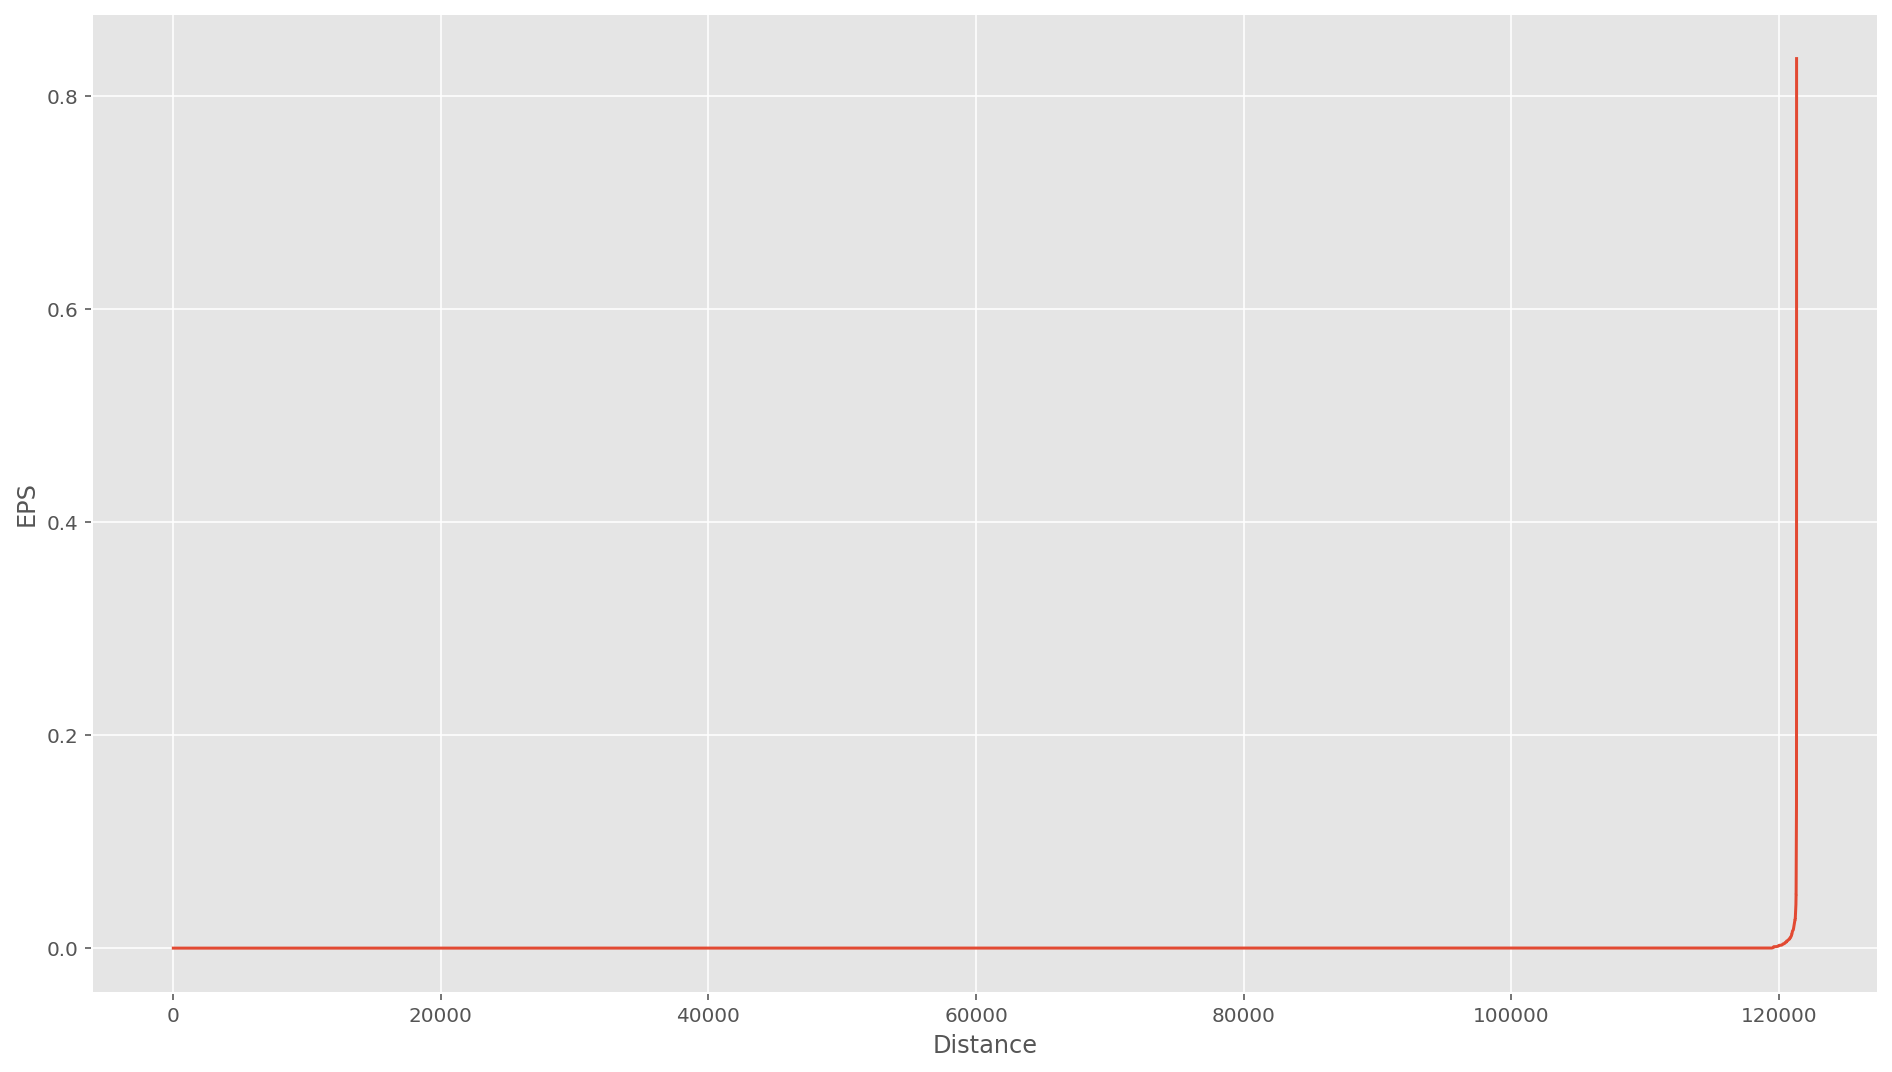

In [163]:
distances=np.sort(distances,axis=0)
distances=distances[:,3] # Take the last columns if K=4(take 3)
plt.ylabel("EPS")
plt.xlabel("Distance")
plt.grid(True)
plt.plot(distances)
plt.show()

**Observations:**
1. The eps value at which there is a significant spike in the distance does not appear to be pronounced.
2. It is almost at 0 value. 
3. Hence we have considered 0.01 as the eps value and continued with the DBScan clustering.

In [99]:
dbscan=DBSCAN(eps=0.01,min_samples=4)
dbscan.fit(df_num_mm)
pd.Series(dbscan.labels_).value_counts()

3      9179
0      4791
239    2910
93     2562
94     2303
       ... 
89        4
113       4
417       4
81        4
188       4
Length: 541, dtype: int64

### Merging all the labels above 0 to form one cluster.

In [100]:
lbl=pd.Series(dbscan.labels_)
lbl.loc[lbl>=0]=0
lbl.value_counts()

 0    120921
-1       422
dtype: int64

**Observation:**<br>
From the above value counts, we can say that cluster label -1 are the potential outliers.

### Scatter plots to detect outliers

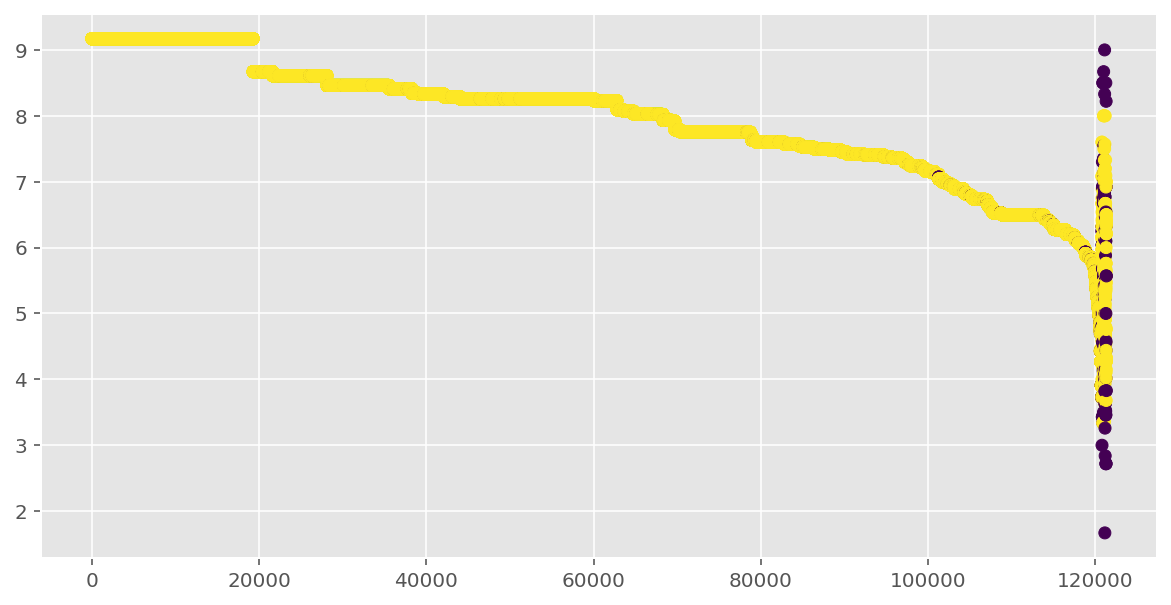

In [101]:
plt.figure(figsize=(10,5))
plt.scatter(anime_data_clustering.index,anime_data_clustering["rating"],c=lbl)
plt.show() 

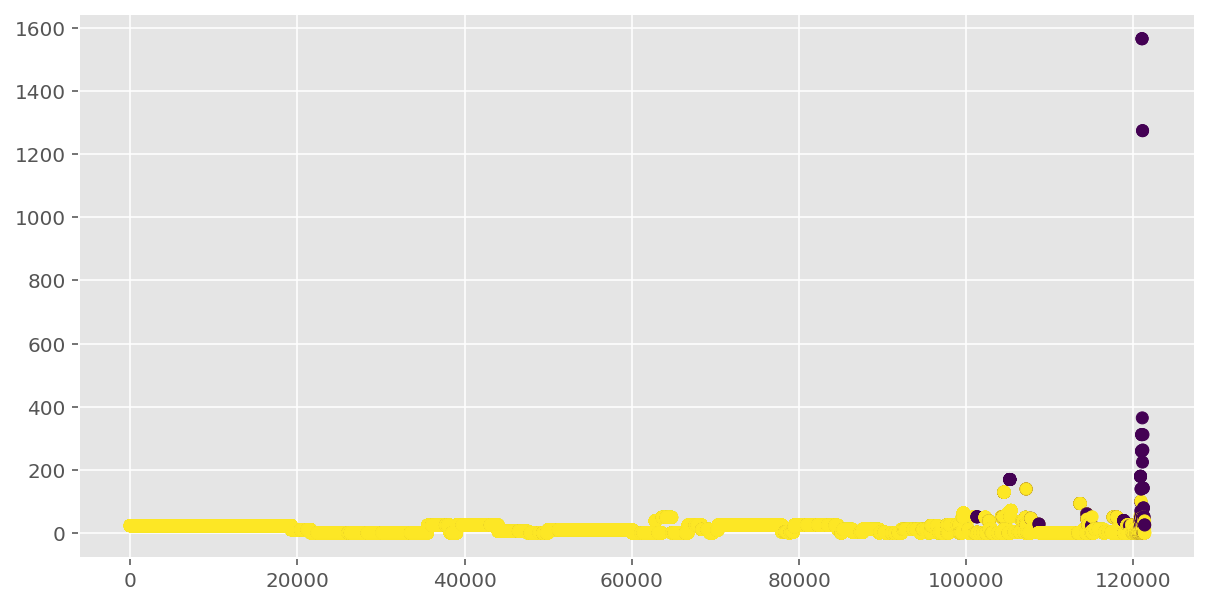

In [102]:
plt.figure(figsize=(10,5))
plt.scatter(anime_data_clustering.index,anime_data_clustering["episodes"],c=lbl)
plt.show() 

**Observation:**<br>
Due to the enormity of the dataset, we see from the above 2 plots that the outliers lie on the far right end of the plot. 

## Application of Dimensionality Reduction to achieve clustering based 'Genre' recommendation

**Note:** <br>
Due to the largeness of the original dataset which is around 78 lakhs records, we have subsetted based on user id less than 1000 to have less dense dataset to work with the computational resources at hand.

In [103]:
anime_fulldata1= anime_fulldata[anime_fulldata.user_id <= 1000]
anime_fulldata1.head()

,anime_id,anime_title,genre,type,episodes,rating,members,user_id,user_rating
0,32281,Kimi no Na wa.,Drama,Movie,1,9.370000,200630,99,5
1,32281,Kimi no Na wa.,Drama,Movie,1,9.370000,200630,152,10
2,32281,Kimi no Na wa.,Drama,Movie,1,9.370000,200630,244,10
3,32281,Kimi no Na wa.,Drama,Movie,1,9.370000,200630,271,10
4,32281,Kimi no Na wa.,Drama,Movie,1,9.370000,200630,278,-1


In [104]:
anime_fulldata1.shape

(96479, 9)

In [105]:
df=anime_fulldata1.copy()
df.head()

,anime_id,anime_title,genre,type,episodes,rating,members,user_id,user_rating
0,32281,Kimi no Na wa.,Drama,Movie,1,9.370000,200630,99,5
1,32281,Kimi no Na wa.,Drama,Movie,1,9.370000,200630,152,10
2,32281,Kimi no Na wa.,Drama,Movie,1,9.370000,200630,244,10
3,32281,Kimi no Na wa.,Drama,Movie,1,9.370000,200630,271,10
4,32281,Kimi no Na wa.,Drama,Movie,1,9.370000,200630,278,-1


#### Creating a contingency frequency table for user_id and anime_title variables.

In [106]:
user_anime = pd.crosstab(df['user_id'], df['anime_title'])
user_anime.head(10)

anime_title,&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,&quot;Bungaku Shoujo&quot; Memoire,&quot;Bungaku Shoujo&quot; Movie,.hack//G.U. Returner,.hack//G.U. Trilogy,.hack//G.U. Trilogy: Parody Mode,.hack//Gift,.hack//Intermezzo,.hack//Liminality,.hack//Quantum,...,gdgd Fairies,gdgd Fairies 2,gdgd Fairies Movie: tte Iu Eiga wa Dou kana...?,iDOLM@STER Xenoglossia,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Principle Component Analysis:
We see that there are 5143 columns which is too complex to analyze.<br>
Hence we have applied PCA and extracted 3 components to work on the data.<br>
This will help us in understanding/visualizing the complex dataset.

In [107]:
pca = PCA(n_components=3)
pca.fit(user_anime)
pca_samples = pca.transform(user_anime)

In [108]:
ps = pd.DataFrame(pca_samples)
ps.head()

,0,1,2
0,3.115480,-4.254569,-0.474463
1,-2.747816,-0.643129,0.610388
2,0.308726,1.048185,0.682656
3,-0.920604,-0.357501,-0.616298
4,9.489573,-2.409411,-0.638494


In [109]:
tocluster = pd.DataFrame(ps[[0,1,2]])

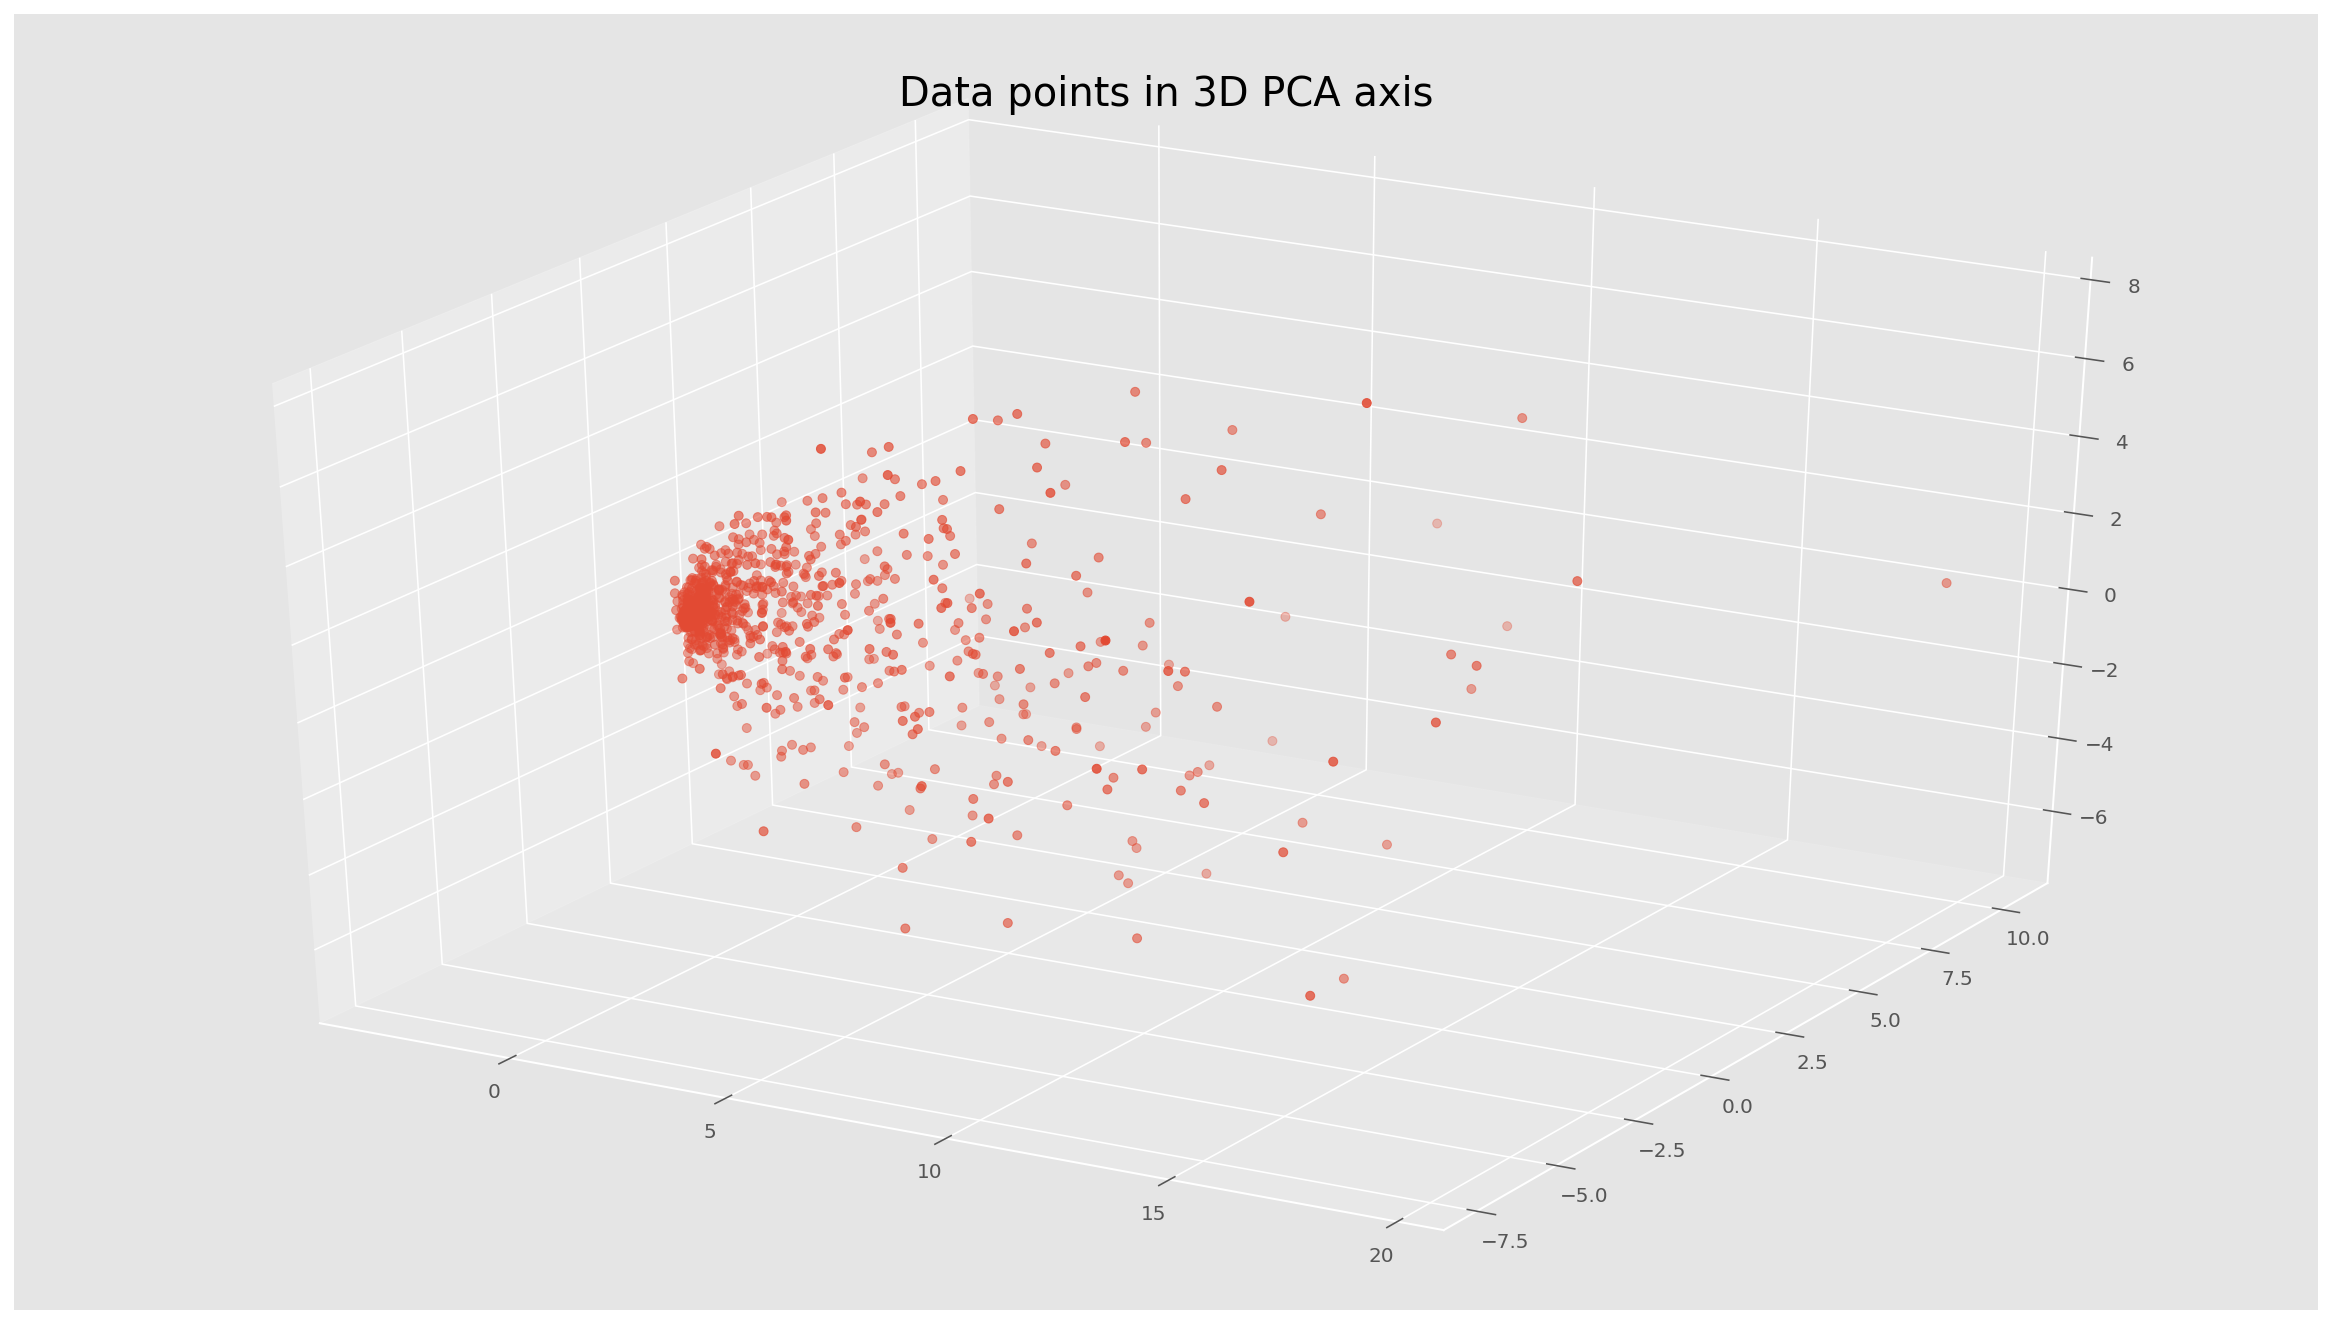

In [110]:
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 9)

plt.style.use('ggplot')
%config InlineBackend.figure_formats = {'png', 'retina'}

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(tocluster[0], tocluster[2], tocluster[1])

plt.title('Data points in 3D PCA axis', fontsize=20)
plt.show()

### Applying KMeans clustering for the selected 3 components from PCA

#### Selecting number of k

In [111]:
scores = []
inertia_list = np.empty(8)

for i in range(2,8):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(tocluster)
    inertia_list[i] = kmeans.inertia_
    scores.append(silhouette_score(tocluster, kmeans.labels_))

In [112]:
scores=[0.45830380453138003,
 0.4447275829364918,
 0.47714839508551904,
 0.5094096147943166,
 0.5171874776060924,
 0.5169551494603674]

In [113]:
inertia_list=np.array([    0.        ,   -40.        , 15566.10945283, 10934.85770102,
        8355.92243999,  6536.89551058,  5480.64369757,  4769.87091951])

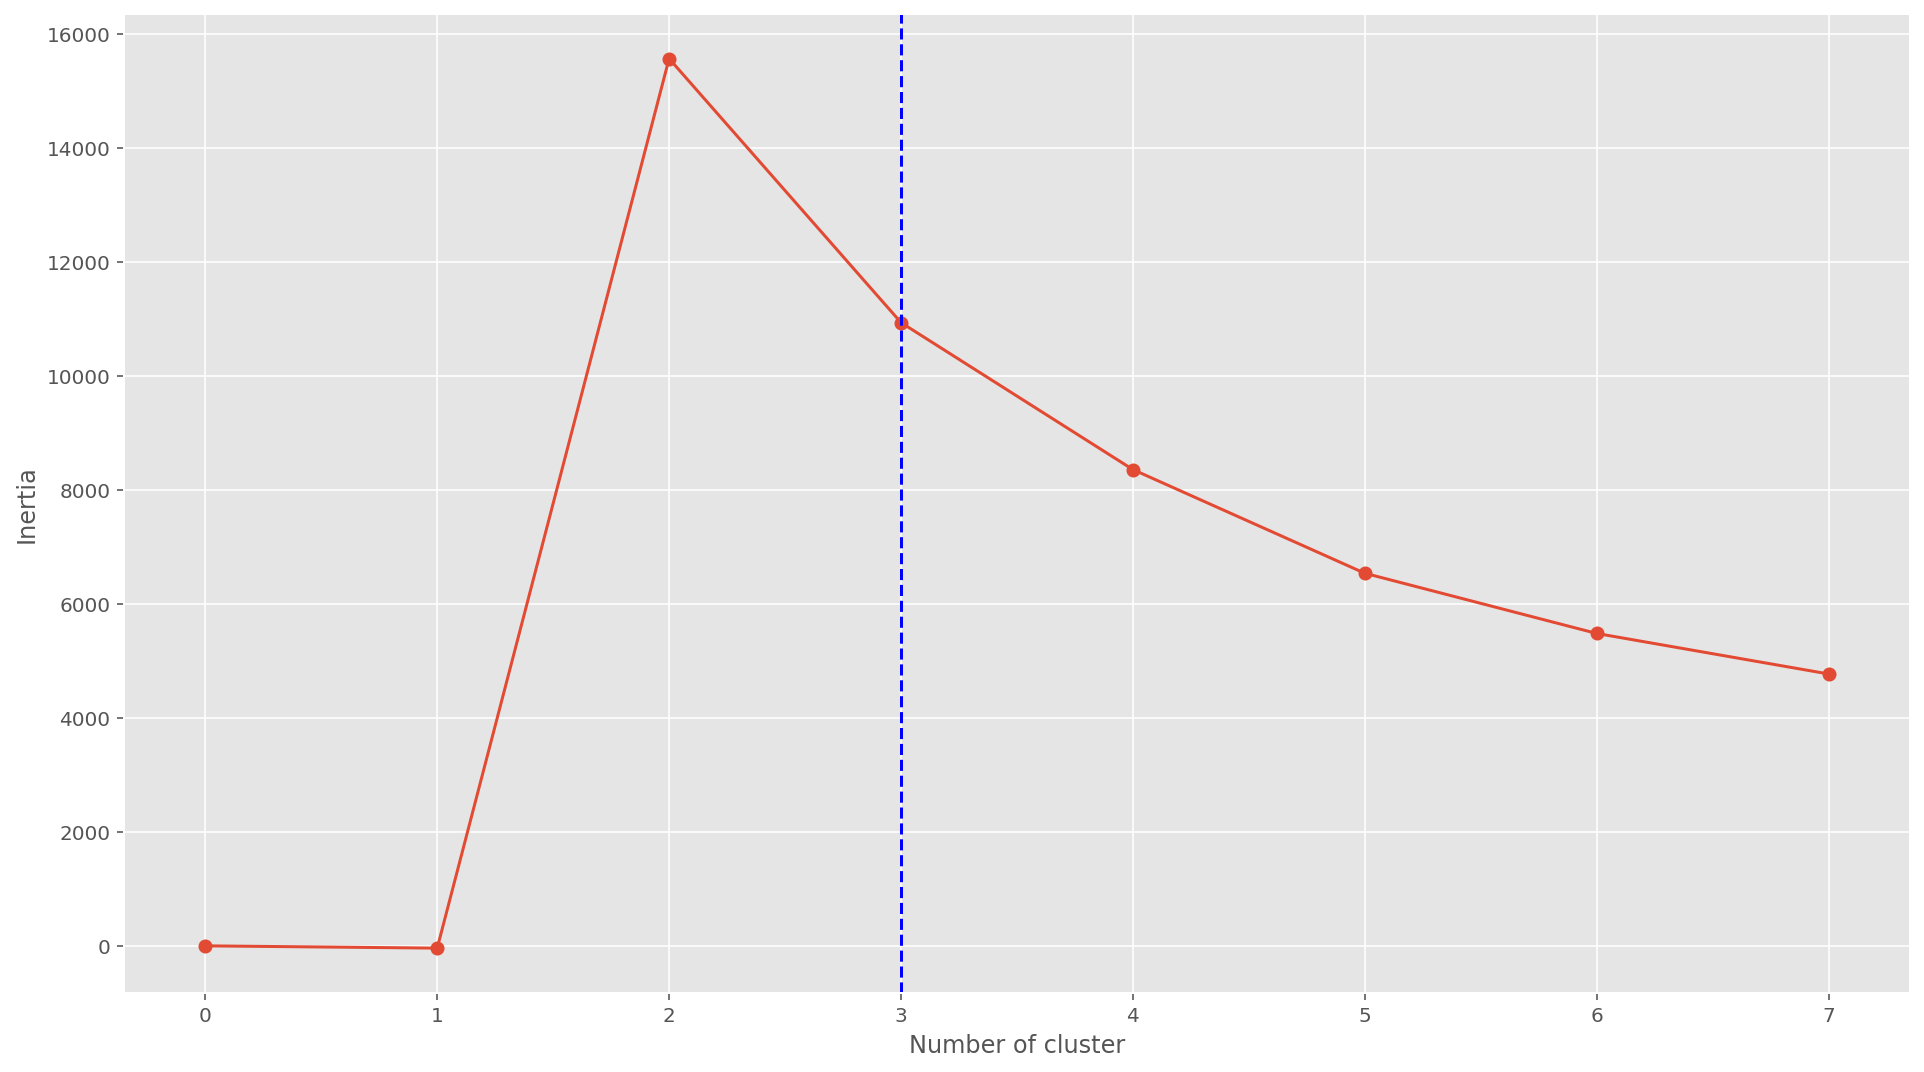

In [114]:
plt.plot(range(0,8),inertia_list,'-o')
plt.xlabel('Number of cluster')
plt.axvline(x=3, color='blue', linestyle='--')
plt.ylabel('Inertia')
plt.show()

**Observations:**<br>
We see that at n_clusters=3 and n_clusters=4, there is an elbow formation. <br>
We have considered n_clusters=3 for better visualization of the cluster formation.

In [115]:
clusterer = KMeans(n_clusters=3,random_state=30).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)

print(centers)

[[ 8.04305393 -1.37630165  0.64307566]
 [-1.8149667  -0.1235814   0.08854927]
 [ 2.14930477  0.85474823 -0.48612685]]


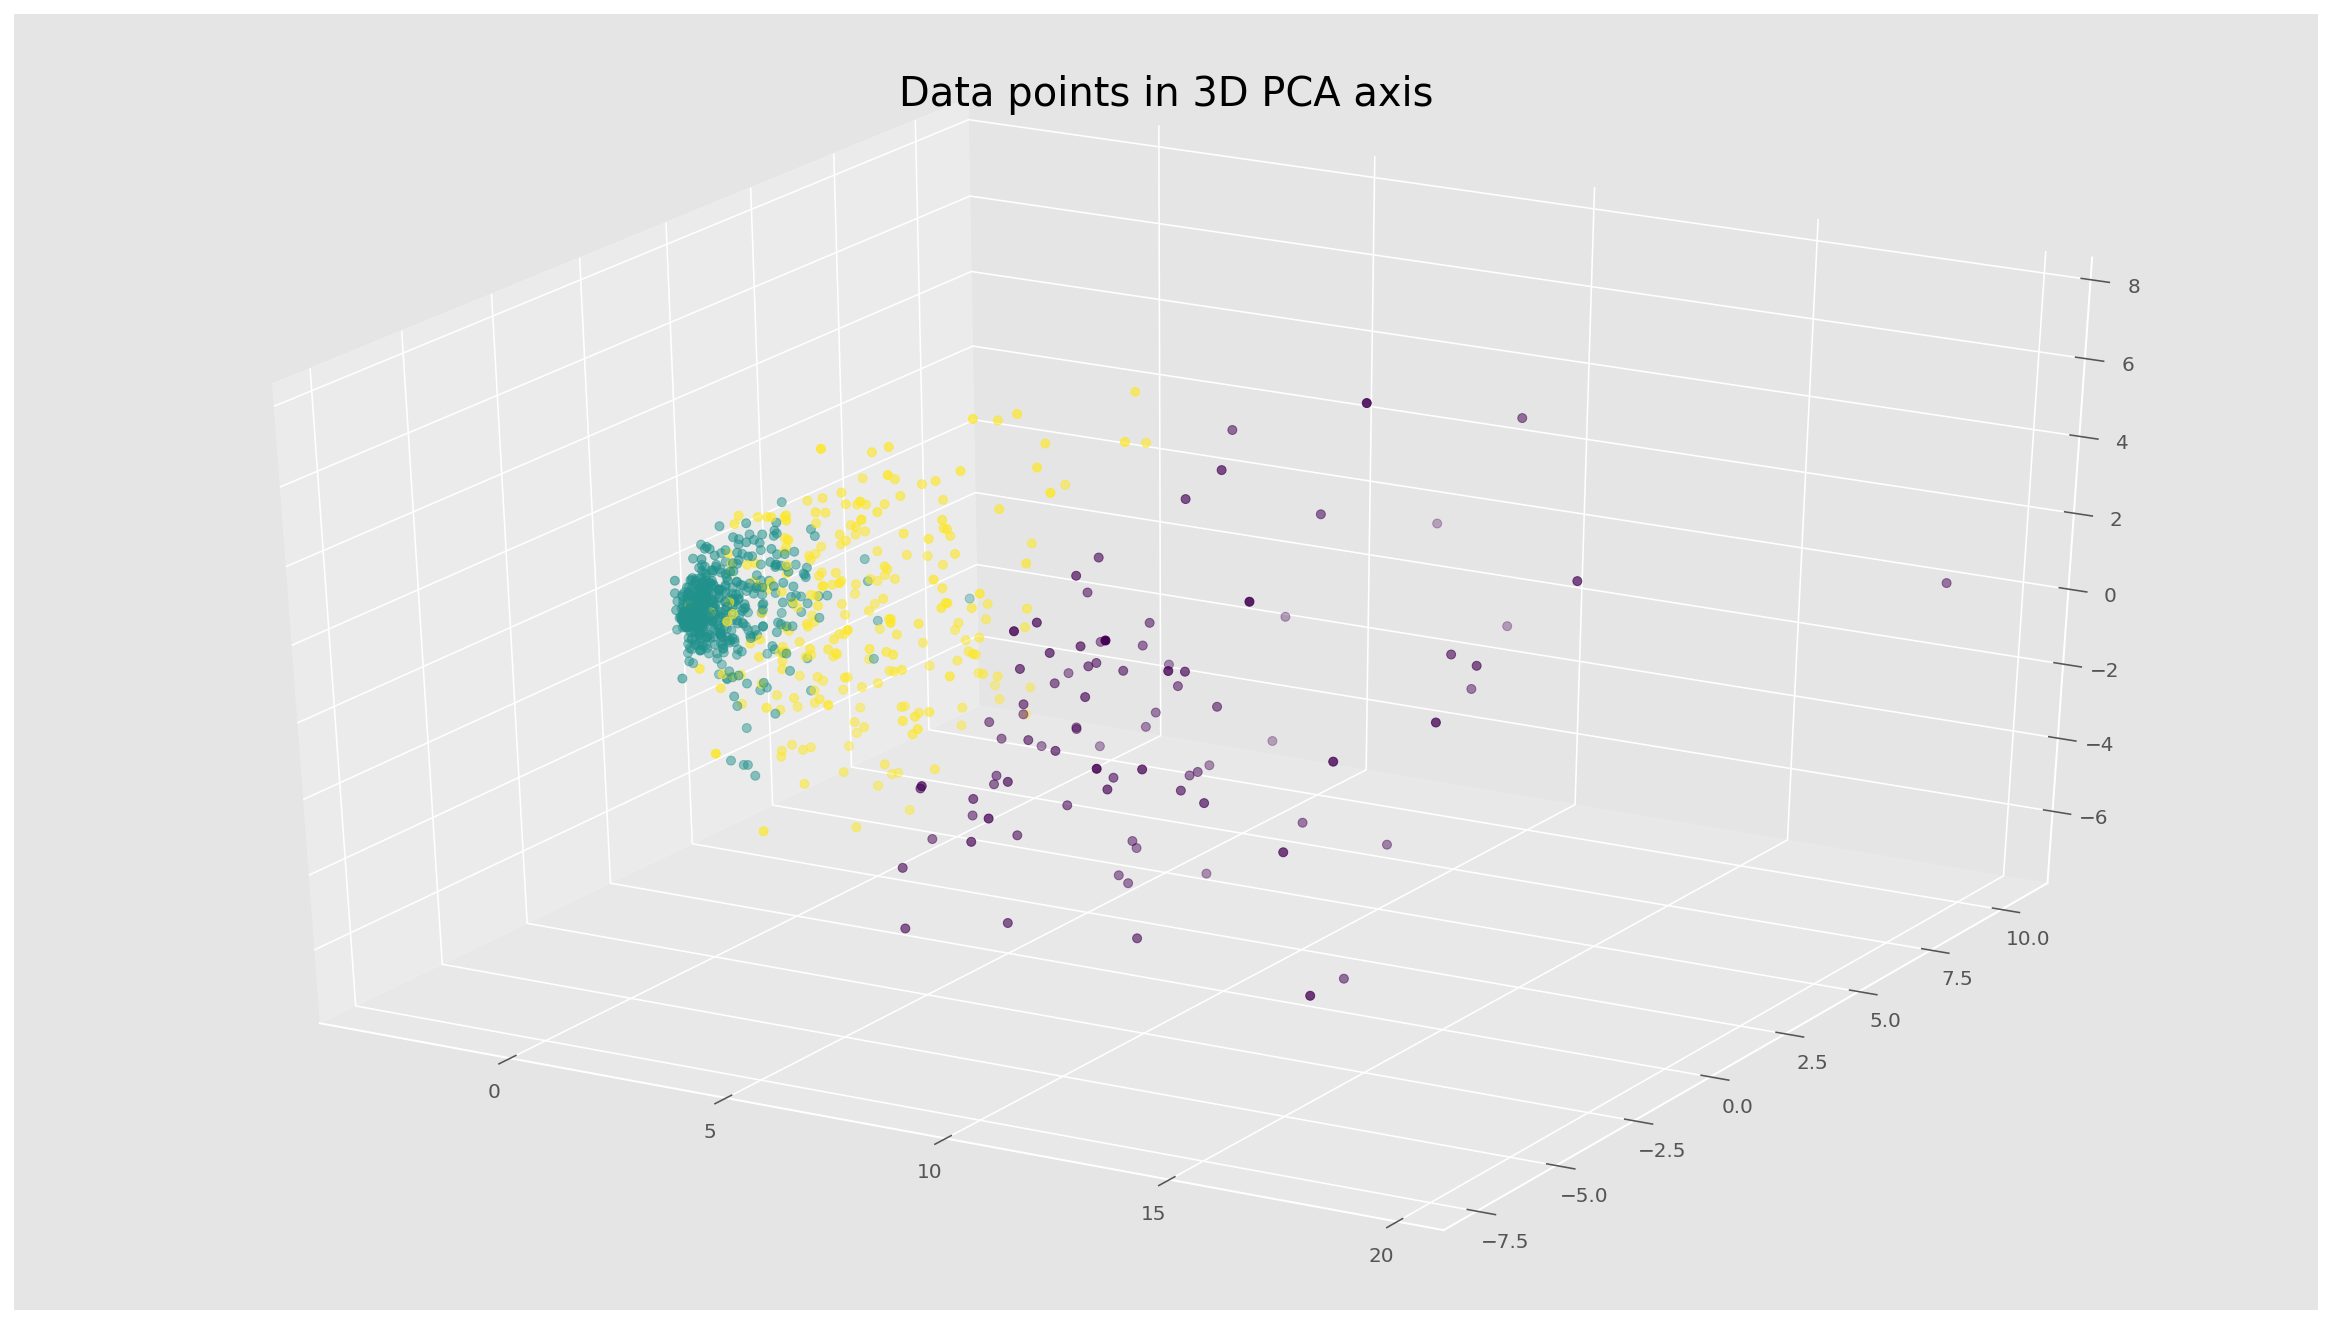

In [116]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(tocluster[0], tocluster[2], tocluster[1], c = c_preds)
plt.title('Data points in 3D PCA axis', fontsize=20)

plt.show()

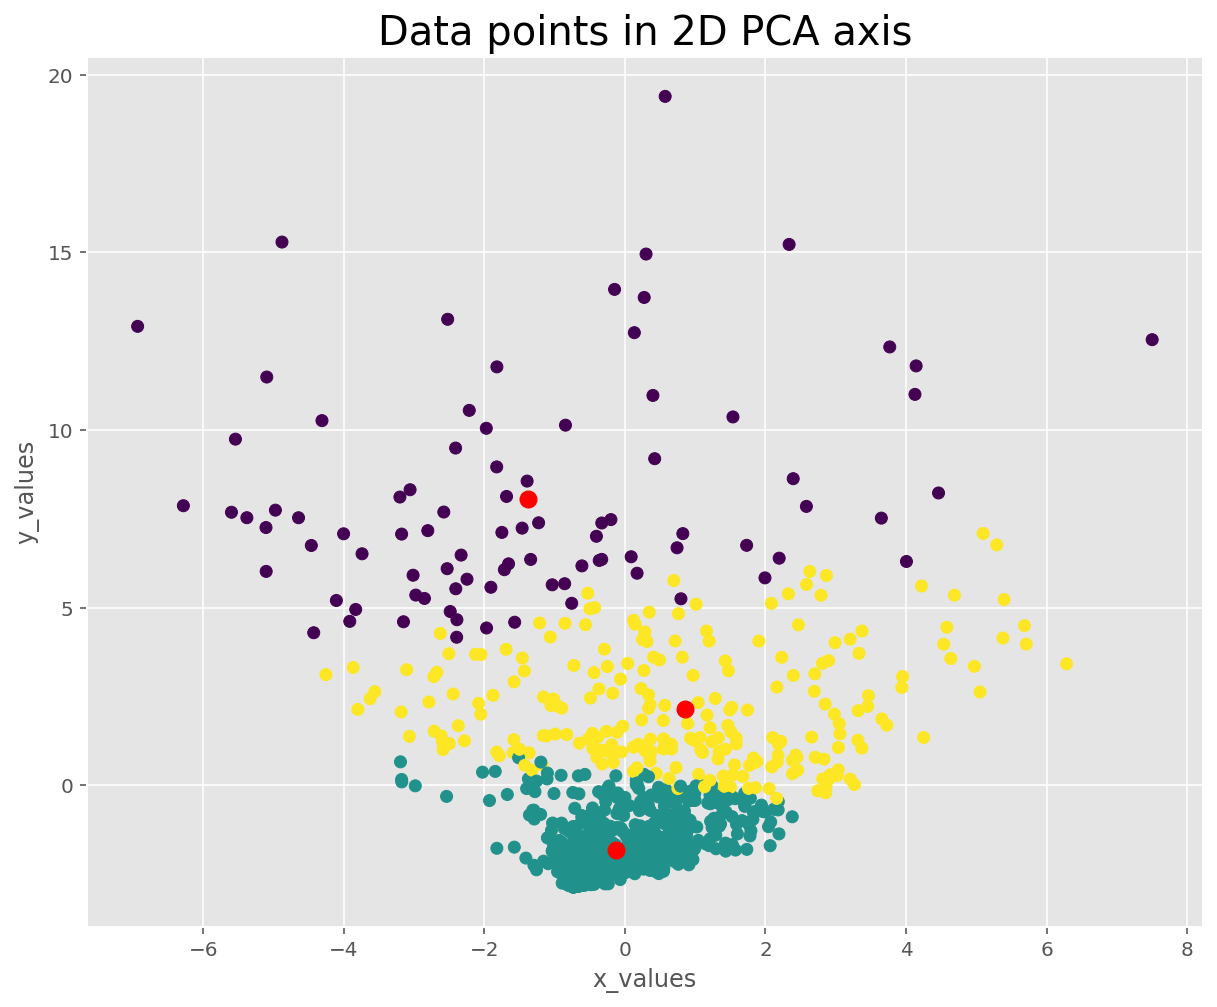

In [117]:
fig = plt.figure(figsize=(10,8))
plt.scatter(tocluster[1],tocluster[0],c = c_preds)
for ci,c in enumerate(centers):
    plt.plot(c[1], c[0], 'o', markersize=8, color='red', alpha=1)

plt.xlabel('x_values')
plt.ylabel('y_values')

plt.title('Data points in 2D PCA axis', fontsize=20)
plt.show()

#### Appending the cluster predictions to the contingnecy table of user_id and anime_title.

In [118]:
user_anime['cluster'] = c_preds
user_anime.head(10)

anime_title,&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,&quot;Bungaku Shoujo&quot; Memoire,&quot;Bungaku Shoujo&quot; Movie,.hack//G.U. Returner,.hack//G.U. Trilogy,.hack//G.U. Trilogy: Parody Mode,.hack//Gift,.hack//Intermezzo,.hack//Liminality,.hack//Quantum,...,gdgd Fairies 2,gdgd Fairies Movie: tte Iu Eiga wa Dou kana...?,iDOLM@STER Xenoglossia,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


#### Finding the average count of the instances in each clusters.

In [119]:
c0 = user_anime[user_anime['cluster']==0].drop('cluster',axis=1).mean()
c1 = user_anime[user_anime['cluster']==1].drop('cluster',axis=1).mean()
c2 = user_anime[user_anime['cluster']==2].drop('cluster',axis=1).mean()

**Top 10 animes in cluster 0**

In [120]:
c0 = user_anime[user_anime['cluster']==0].drop('cluster',axis=1).mean()
c0.sort_values(ascending=False)[0:10]

anime_title
Sword Art Online                                      0.954545
Yahari Ore no Seishun Love Comedy wa Machigatteiru.   0.897727
No Game No Life                                       0.886364
Date A Live                                           0.886364
Shingeki no Kyojin                                    0.863636
Mirai Nikki (TV)                                      0.852273
Angel Beats!                                          0.852273
Chuunibyou demo Koi ga Shitai!                        0.852273
High School DxD                                       0.852273
Tokyo Ghoul                                           0.829545
dtype: float64

**Top 10 animes in cluster 1**

In [121]:
c1 = user_anime[user_anime['cluster']==1].drop('cluster',axis=1).mean()
c1.sort_values(ascending=False)[0:10]

anime_title
Death Note                         0.450223
Sword Art Online                   0.398217
Shingeki no Kyojin                 0.353640
Angel Beats!                       0.282318
Fullmetal Alchemist: Brotherhood   0.267459
Elfen Lied                         0.258544
Naruto                             0.251114
Mirai Nikki (TV)                   0.242199
Ao no Exorcist                     0.227340
Highschool of the Dead             0.224368
dtype: float64

**Top 10 animes in cluster 2**

In [122]:
c2 = user_anime[user_anime['cluster']==2].drop('cluster',axis=1).mean()
c2.sort_values(ascending=False)[0:10]

anime_title
Shingeki no Kyojin                 0.828452
Sword Art Online                   0.794979
Angel Beats!                       0.736402
Death Note                         0.719665
Mirai Nikki (TV)                   0.673640
Highschool of the Dead             0.615063
Code Geass: Hangyaku no Lelouch    0.606695
Toradora!                          0.606695
Fullmetal Alchemist: Brotherhood   0.606695
No Game No Life                    0.602510
dtype: float64

# Recommendation Systems
## Popularity based recommendation

In [134]:
popular_anime = anime_fulldata.groupby('anime_title').agg({'rating':'mean', 'members': 'count'})
popular_anime = popular_anime[popular_anime['members'] > 20000]
popular_anime = popular_anime.sort_values(by = 'rating', ascending = False)
popular_anime.head(10)

,rating,members
anime_title,,
Fullmetal Alchemist: Brotherhood,9.260000,24574
Code Geass: Hangyaku no Lelouch R2,8.980000,24242
Sen to Chihiro no Kamikakushi,8.930000,22974
Code Geass: Hangyaku no Lelouch,8.830000,27718
Death Note,8.710000,39340
Shingeki no Kyojin,8.540000,29584
Toradora!,8.450000,24283
Angel Beats!,8.390000,27183
Fullmetal Alchemist,8.330000,25032


**Fullmetal Alchemist: Brotherhood is the most popular anime**

## Content based recommendation

In [135]:
copy_anime = anime_fulldata.copy()
copy_anime = copy_anime.drop_duplicates()
copy_anime.set_index('anime_title', inplace=True)
copy_anime.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7813606 entries, Kimi no Na wa. to Yasuji no Pornorama: Yacchimae!!
Data columns (total 8 columns):
 #   Column       Dtype  
---  ------       -----  
 0   anime_id     int64  
 1   genre        object 
 2   type         object 
 3   episodes     int32  
 4   rating       float64
 5   members      int64  
 6   user_id      int64  
 7   user_rating  int64  
dtypes: float64(1), int32(1), int64(4), object(2)
memory usage: 506.7+ MB


In [136]:
df = copy_anime[['user_id', 'anime_id', 'rating', 'genre']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7813606 entries, Kimi no Na wa. to Yasuji no Pornorama: Yacchimae!!
Data columns (total 4 columns):
 #   Column    Dtype  
---  ------    -----  
 0   user_id   int64  
 1   anime_id  int64  
 2   rating    float64
 3   genre     object 
dtypes: float64(1), int64(2), object(1)
memory usage: 298.1+ MB


In [137]:
df2 = pd.get_dummies(df)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7813606 entries, Kimi no Na wa. to Yasuji no Pornorama: Yacchimae!!
Data columns (total 42 columns):
 #   Column               Dtype  
---  ------               -----  
 0   user_id              int64  
 1   anime_id             int64  
 2   rating               float64
 3   genre_Action         uint8  
 4   genre_Adventure      uint8  
 5   genre_Cars           uint8  
 6   genre_Comedy         uint8  
 7   genre_Dementia       uint8  
 8   genre_Demons         uint8  
 9   genre_Drama          uint8  
 10  genre_Ecchi          uint8  
 11  genre_Fantasy        uint8  
 12  genre_Game           uint8  
 13  genre_Harem          uint8  
 14  genre_Hentai         uint8  
 15  genre_Historical     uint8  
 16  genre_Horror         uint8  
 17  genre_Josei          uint8  
 18  genre_Kids           uint8  
 19  genre_Magic          uint8  
 20  genre_MartialArts    uint8  
 21  genre_Mecha          uint8  
 22  genre_Military       uint8  
 23 

In [138]:
nn = NearestNeighbors(metric='cosine')
nn.fit(df2)

NearestNeighbors(metric='cosine')

In [139]:
def rec_by_genre(genre):

    anime_id = copy_anime[copy_anime['genre'] == genre].head(1).values[0][0]

    dis, ind = nn.kneighbors(X = df2[df2['anime_id']==anime_id].iloc[0].values.reshape(1, -1), n_neighbors=6)
  
    recommended = pd.DataFrame()
    for i in range(1, 6):
        new_rec = pd.DataFrame(copy_anime[ copy_anime.index == df2.index[ind[0][i]] ].iloc[0]).T
        recommended = pd.concat([recommended, new_rec], axis=0)
    return recommended

In [140]:
genre = input('Enter the genre')
recommendtions = rec_by_genre(genre)
recommendtions

Enter the genreAction


,anime_id,genre,type,episodes,rating,members,user_id,user_rating
Pokemon Diamond &amp; Pearl: Giratina to Sora no Hanataba Sheimi,4026,Action,Movie,1,7.100000,32654,3,7
Sekirei,4063,Action,TV,12,7.400000,182713,1,-1
Afro Samurai: Resurrection,4970,Action,Movie,1,7.460000,51064,4,-1
Ookami to Koushinryou II,5341,Adventure,TV,12,8.460000,210491,4,-1
Sekirei,4063,Action,TV,12,7.400000,182713,1,-1


## Collaborative filtering

In [144]:
anime_fulldata_new.head()

,anime_id,anime_title,genre,type,episodes,rating,members,user_id,user_rating
0,9253,Steins;Gate,Sci-Fi,TV,24,9.170000,673572,5,9
1,9253,Steins;Gate,Sci-Fi,TV,24,9.170000,673572,10,-1
2,9253,Steins;Gate,Sci-Fi,TV,24,9.170000,673572,11,7
3,9253,Steins;Gate,Sci-Fi,TV,24,9.170000,673572,12,10
4,9253,Steins;Gate,Sci-Fi,TV,24,9.170000,673572,13,-1


In [145]:
#df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML-3 Project/5genre.csv')
reader = Reader(rating_scale = (-1, 10))
rating_data = Dataset.load_from_df(anime_fulldata_new[['user_id', 'anime_id', 'user_rating']], reader)

In [146]:
item_id = anime_fulldata_new['anime_id'].unique()
test_set = [[26291, iid, 4] for iid in item_id]

trainsetfull = rating_data.build_full_trainset()

algo = SVDpp(random_state = 4)
algo.fit(trainsetfull)

pred = algo.test(test_set)
rec = pd.DataFrame(pred).sort_values(by = 'est', ascending = False)
rec.head()

,uid,iid,r_ui,est,details
0,26291,9253,4,7.412172,{'was_impossible': False}
9,26291,7465,4,7.340312,{'was_impossible': False}
24,26291,3369,4,7.231417,{'was_impossible': False}
64,26291,5895,4,7.147063,{'was_impossible': False}
13,26291,645,4,7.127227,{'was_impossible': False}


In [147]:
print('Recommended anime for user id: 26297 are')
for i in range(5):
    anime_id = rec.iloc[i]['iid']
    title = anime_fulldata_new[anime_fulldata_new['anime_id'] == anime_id].iloc[0]['anime_title']
    genre = anime_fulldata_new[anime_fulldata_new['anime_id'] == anime_id].iloc[0]['genre']
    est = str(round(rec.iloc[i]['est'], 2))

    print(str(i+1)+'.','\033[1m'+ title+'\033[0m', 'of genre', genre, 'with estimation of', est)

Recommended anime for user id: 26297 are
1. Steins;Gate of genre Sci-Fi with estimation of 7.41
2. Eve no Jikan (Movie) of genre Sci-Fi with estimation of 7.34
3. Shoubushi Densetsu Tetsuya of genre Game with estimation of 7.23
4. Tistou Midori no Oyayubi of genre Historical with estimation of 7.15
5. Hikaru no Go: Journey to the North Star Cup of genre Game with estimation of 7.13


# Association

In [148]:
anime_fulldata=pd.merge(anime,rating,on='anime_id',suffixes= ['', '_user'])
anime_fulldata = anime_fulldata.rename(columns={'name': 'anime_title', 'rating_user': 'user_rating'})
anime_fulldata_sample=anime_fulldata.sample(frac=0.1,random_state=4)
anime_fulldata_sample.head()

,anime_id,anime_title,genre,type,episodes,rating,members,user_id,user_rating
705329,205,Samurai Champloo,"Action,Adventure,Comedy,Historical,Samurai,Sho...",TV,26,8.500000,390076,24920,10
1607582,6702,Fairy Tail,"Action,Adventure,Comedy,Fantasy,Magic,Shounen",TV,175,8.220000,584590,2912,9
752146,523,Tonari no Totoro,"Adventure,Comedy,Supernatural",Movie,1,8.480000,271484,17647,7
2359082,30831,Kono Subarashii Sekai ni Shukufuku wo!,"Adventure,Comedy,Fantasy,Supernatural",TV,10,8.030000,244877,69254,7
6536135,11703,Code:Breaker,"Action,Comedy,School,Shounen,SuperPower,Supern...",TV,13,7.030000,135255,61508,4


In [149]:
anime_fulldata_sample=anime_fulldata_sample.dropna()
records=anime_fulldata_sample['genre'].apply(lambda x:x.split(','))

records=[i+np.zeros(14-len(i),dtype=int).tolist() for i in records]

In [150]:
genre_list = pd.DataFrame(records).replace({0:"None"}).values.tolist()

In [151]:
te = TransactionEncoder()
te_ary = te.fit(genre_list).transform(genre_list)
df1 = pd.DataFrame(te_ary, columns=te.columns_)

In [152]:
df1=df1.replace({True:1,False:0})
df1.head()

,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,...,ShounenAi,SliceofLife,Space,Sports,SuperPower,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0


In [153]:
df1.drop('None',1,inplace=True)

### Support for each item

In [154]:
%%time
freq_items = apriori(df1,min_support = 0.1, use_colnames=True)
freq_items=freq_items.sort_values(by='support',ascending=False)
freq_items

Wall time: 5.44 s


,support,itemsets
2,0.501252,(Comedy)
0,0.417622,(Action)
7,0.319306,(Romance)
3,0.268599,(Drama)
5,0.257954,(Fantasy)
12,0.251622,(Supernatural)
8,0.241007,(School)
10,0.240115,(Shounen)
1,0.216653,(Adventure)
9,0.206317,(Sci-Fi)


## Building Association Rules

In [155]:
rules = association_rules(freq_items, metric='confidence',min_threshold=0.2)
rules.sort_values(by='confidence',ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,(School),(Comedy),0.241007,0.501252,0.178454,0.740453,1.477207,0.057649,1.921611
4,(Shounen),(Comedy),0.240115,0.501252,0.157826,0.657295,1.311305,0.037468,1.455325
10,(Adventure),(Fantasy),0.216653,0.257954,0.138672,0.640066,2.481316,0.082786,2.061618
1,(Romance),(Comedy),0.319306,0.501252,0.193649,0.606466,1.209901,0.033595,1.267356
19,(Adventure),(Action),0.216653,0.417622,0.127612,0.589016,1.410404,0.037133,1.417033
25,(Sci-Fi),(Action),0.206317,0.417622,0.117907,0.571485,1.368426,0.031745,1.359061
9,(Fantasy),(Action),0.257954,0.417622,0.146296,0.567140,1.358022,0.038569,1.345419
15,(Shounen),(Action),0.240115,0.417622,0.130642,0.544079,1.302802,0.030364,1.277366
12,(School),(Romance),0.241007,0.319306,0.131065,0.543823,1.703139,0.054110,1.492171
11,(Fantasy),(Adventure),0.257954,0.216653,0.138672,0.537585,2.481316,0.082786,1.694035


**Genre School is having highest confidence with genre comedy.**

## Conclusion

1. We have performed clustering analysis using KMeans, DBSCAN and saw various segments on which we can divide the dataset and detected the outliers
2. Applied dimensionality reductions such as PCA and visualized the clusters in 3D as well as 2D planes
3. Built different types of recommendation systems and verified the quality of recommendation
4. Performed market basket analysis on the genres and found out associations among the genres